In [1]:
import EITfunc.EITlook as eit

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.cm as cmx
import matplotlib.colorbar as cb
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

import os

from astropy import units as u
from astropy.constants import G
from astropy.io import ascii, fits
from astropy.table import Table
from astropy.timeseries import LombScargle
import astropy.time

import scipy.optimize as sciop
from scipy.stats import mode, binned_statistic
from scipy.signal import medfilt

import time

%matplotlib inline

(10277, 5)


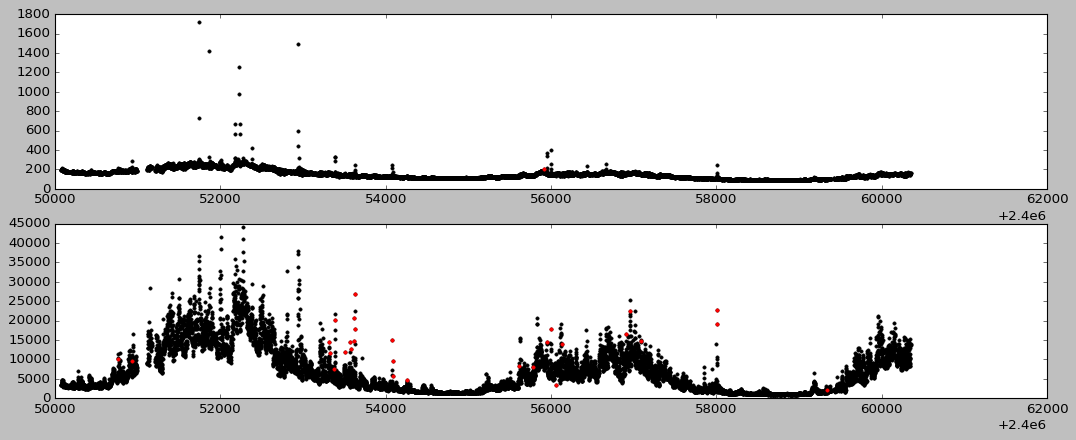

1
9.730466089325679e-05
29
0.002821835165904447


In [23]:
#columns:
# t_obs[JD] firstOrderFlux[counts/s] firstOrderFluxUnc[counts/s] centralOrderFlux[counts/s] centralOrderFluxUnc[counts/s]
#days without observations have flux=nan, fluxerr=nan
sem = np.genfromtxt("../data/CELIAS-SEM/SEMDailyData_norm.txt")
#print(sem)
print(np.shape(sem))

# outlier rejection? just get rid of the ones that are uncertain by more than their own value
ch1_UncMask = (sem[:,2]/sem[:,1] >= 1)
ch0_UncMask = (sem[:,4]/sem[:,3] >= 1)

fig, axes = plt.subplots(2,1,figsize=(16,6))
axes[0].plot(sem[:,0],sem[:,1],'k.')
axes[0].plot(sem[:,0][ch1_UncMask],sem[:,1][ch1_UncMask],'r.')

axes[1].plot(sem[:,0],sem[:,3],'k.')
axes[1].plot(sem[:,0][ch0_UncMask],sem[:,3][ch0_UncMask],'r.')
plt.show()

ch1unc_rejected = len(sem[:,0][ch1_UncMask])
print(ch1unc_rejected)
ch1unc_dutyCycle = ch1unc_rejected/len(sem[:,0])
print(ch1unc_dutyCycle)

ch0unc_rejected = len(sem[:,0][ch0_UncMask])
print(ch0unc_rejected)
ch0unc_dutyCycle = ch0unc_rejected/len(sem[:,0])
print(ch0unc_dutyCycle)

#ch1_medfilt = medfilt(sem[:,1],kernel_size=11)
#ch0_medfilt = medfilt(sem[:,3],kernel_size=11)
#ch1_outlierMask = ((sem[:,1] - ch1_medfilt) >= 5.*sem[:,2])
#ch0_outlierMask = ((sem[:,3] - ch0_medfilt) >= 5.*sem[:,4])

for colIdx in [1,2,3,4]:
    sem[:,colIdx][ch1_UncMask] = np.nan
    sem[:,colIdx][ch0_UncMask] = np.nan

In [24]:
noObs = np.isnan(sem[:,1])
n_noObs = len(sem[:,0][noObs])
print(n_noObs)
dutyCycle = n_noObs/len(sem)
print(dutyCycle)

267
0.025980344458499564


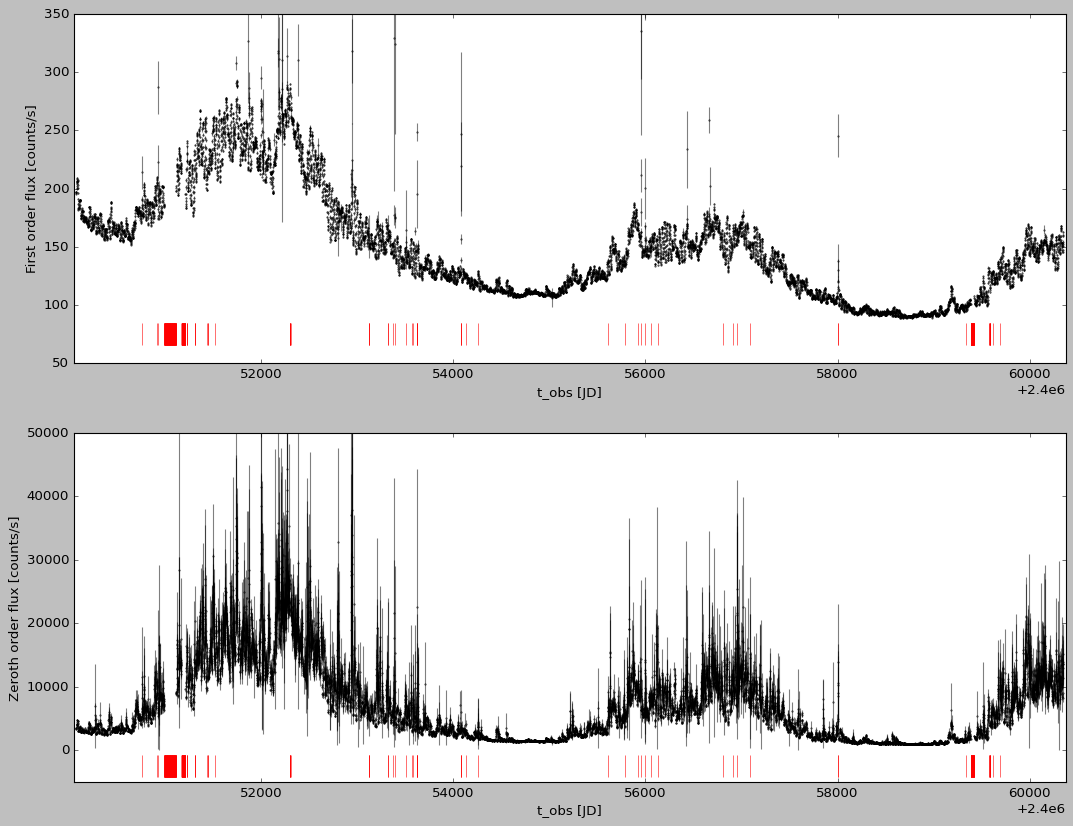

In [25]:
fig, axes = plt.subplots(2,1,figsize=(16,12))
axes[0].errorbar(sem[:,0],sem[:,1],yerr=sem[:,2],marker='.',ms=3,color='k',ls='None',capsize=0,elinewidth=1,alpha=0.5)
axes[0].plot(sem[:,0][noObs],75*np.ones_like(sem[:,0][noObs]),marker='|',color='r',ls='None',ms=20)
axes[0].set_ylim(50,350)
axes[0].set_ylabel("First order flux [counts/s]")

axes[1].errorbar(sem[:,0],sem[:,3],yerr=sem[:,4],marker='.',ms=3,color='k',ls='None',capsize=0,elinewidth=1,alpha=0.5)
axes[1].plot(sem[:,0][noObs],-2500*np.ones_like(sem[:,0][noObs]),marker='|',color='r',ls='None',ms=20)
axes[1].set_ylim(-5000,50000)
axes[1].set_ylabel("Zeroth order flux [counts/s]")

for ax in axes:
    ax.set_xlabel("t_obs [JD]")
    ax.set_xlim(sem[0,0]-25,sem[-1,0]+25)
plt.show()

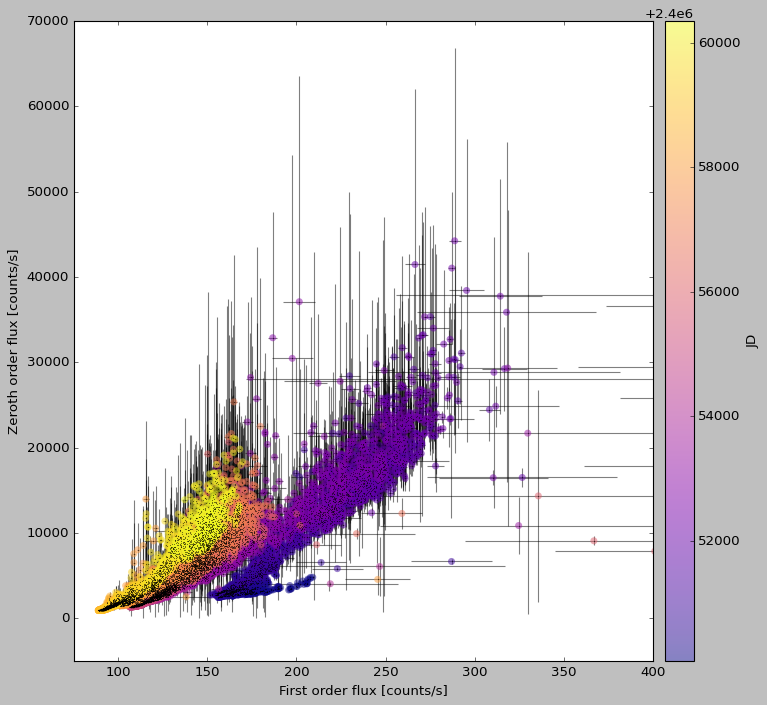

In [33]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.errorbar(sem[:,1],sem[:,3],xerr=sem[:,2],yerr=sem[:,4],marker='.',ms=1,color='k',ls='None',capsize=0,elinewidth=1,alpha=0.5,zorder=1)
cs = ax.scatter(sem[:,1],sem[:,3],c=sem[:,0],marker='o',s=40,edgecolor='None',ls='None',alpha=0.5,zorder=1,cmap='plasma')

ax.set_xlabel("First order flux [counts/s]")
ax.set_ylabel("Zeroth order flux [counts/s]")
ax.set_xlim(75,400)
ax.set_ylim(-5000,70000)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad="2%")
fig.add_axes(cax)
fig.colorbar(cs, cax=cax,label="JD")
plt.show()